In [ ]:
!pip install opendatasets --upgrade --quiet
%config Completer.use_jedi = False
%matplotlib inline

In [ ]:
import torch
import torchvision
from PIL import Image
import numpy as np
import pandas as pd
import sklearn
import time
import copy
import glob
import random

from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset,  DataLoader
from torchvision import transforms
from torchvision.models import resnet18, resnet34


In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: iamsanaullah
Your Kaggle Key: ··········


100%|██████████| 2.29G/2.29G [00:18<00:00, 130MB/s] 


In [ ]:
train_normal = glob.glob("/content/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/*")
train_pneumonia = glob.glob("/content/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/*")


test_normal = glob.glob("/content/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/*")
test_pneumonia = glob.glob("/content/chest-xray-pneumonia/chest_xray/chest_xray/test/PNEUMONIA/*")


In [ ]:
train_normal

In [ ]:
train_paths = train_normal + train_pneumonia
test_paths = test_normal + test_pneumonia

In [ ]:
train_labels = [0] * len(train_normal) + [1] * len(train_pneumonia)
test_labels = [0] * len(test_normal) + [1] * len(test_pneumonia)

In [ ]:
print(len(train_paths), len(train_labels))
print(len(test_paths), len(test_labels))

5216 5216
624 1731


In [ ]:
train_paths, valid_paths, train_labels, valid_lables = train_test_split(train_paths,train_labels,stratify = train_labels)



In [ ]:
def show_random_images():
  path_random_normal = random.choice(train_normal)
  path_random_abnormal = random.choice(train_pneumonia)

  flg = plt.figure(figsize=(10, 10))

  ax1 = plt.subplot(1, 2, 1)
  ax1.imshow(Image.open(path_random_normal).convert("LA"))
  ax1.set_title("Normal X-ray")


  ax2 = plt.subplot(1, 2, 2)
  ax2.imshow(Image.open(path_random_abnormal).convert("LA"))
  ax2.set_title("Abnormal X-ray")

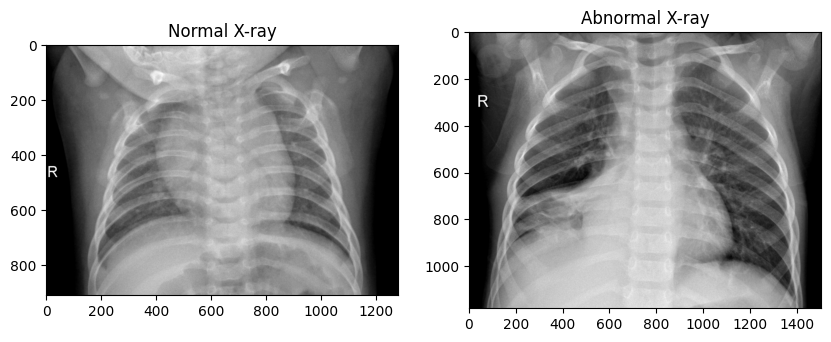

In [ ]:
show_random_images()

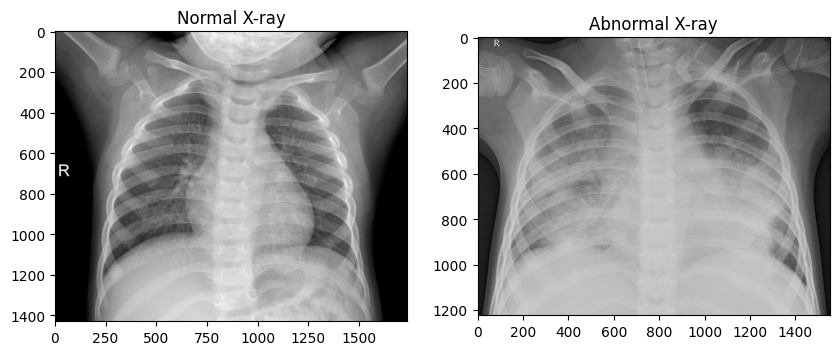

In [ ]:
show_random_images()

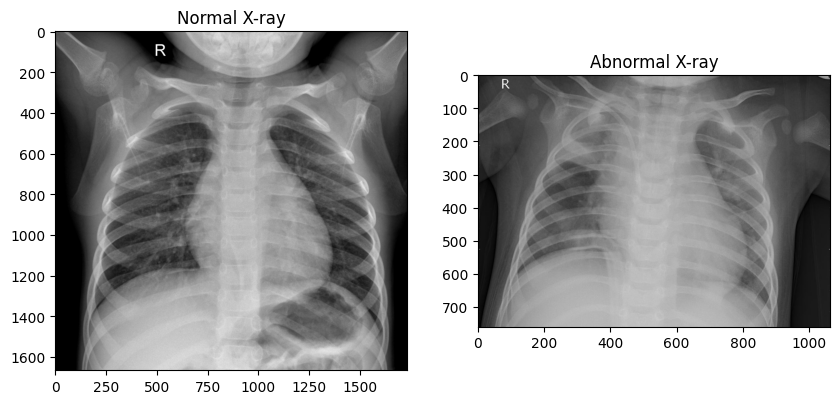

In [ ]:
show_random_images()

In [ ]:
class XrayDataset(Dataset):
  def __init__(self, paths, labels, transform=None):
    self.paths = paths
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.paths)

  def __getitem__(self, index):
    path = self.paths[index]
    image = Image.open(path).convert("RGB")

    if self.transform:
      image = self.transform(image)

    label = self.labels[index]
    label = torch.tensor([label])

    return image, label


In [ ]:
train_dataset = XrayDataset(train_paths, train_labels)

In [ ]:
len(train_dataset)

3912

In [ ]:
next(iter(train_dataset))

(<PIL.Image.Image image mode=RGB size=1658x1145>, tensor([1]))

In [ ]:
resnet = resnet18()
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
class PneumoniaNet(nn.Module):
  def __init__(self, pretrained=True):
    super(PneumoniaNet, self).__init__()
    self.backbone = resnet18(pretrained = pretrained)
    self.fc = nn.Linear(in_features=512, out_features=1)

  def forward(self, x):
    x = self.backbone.conv1(x)
    x = self.backbone.bn1(x)
    x = self.backbone.relu(x)
    x = self.backbone.maxpool(x)

    x = self.backbone.layer1(x)
    x = self.backbone.layer2(x)
    x = self.backbone.layer3(x)
    x = self.backbone.layer4(x)

    x = self.backbone.avgpool(x)

    x = x.view(x.size(0), 512)
    x = self.fc(x)

    return x



In [ ]:
image_size = (500, 500)

train_transform = transforms.Compose([
  transforms.ToTensor(), transforms.RandomRotation (degrees=15),
  transforms.Resize(size=image_size),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transform= transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize(size = image_size),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.2251])])

train_dataset = XrayDataset(train_paths, train_labels, train_transform)
valid_dataset = XrayDataset(valid_paths, valid_lables, test_transform)

In [ ]:
pretrained = True

model = PneumoniaNet(pretrained=pretrained)
num_epochs = 5
lr = 3e-3
train_batch_size=16
valid_batch_size=16
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, num_workers=5, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=valid_batch_size, num_workers=5, shuffle=False)

dataloaders = {
    "train": train_dataloader,
    "val": valid_dataloader
}

logging_steps = {
    "train": len(dataloaders["train"]) // 10,
    "val": len(dataloaders["val"])//10
}

data_sizes = {
    "train": len(train_dataset),
    "val": len(valid_dataset)
}

batch_sizes = {
    "train": train_batch_size,
    "val": valid_batch_size
}


criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=lr)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 85.7MB/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current

In [ ]:
def get_default_device():
  """ Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [ ]:

device = get_default_device()
device

device(type='cpu')

In [ ]:
model = model.to(device)
model

PneumoniaNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
! nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
def train_model(model, criterion, optimizer, num_epochs, device="cuda"):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0

  for epoch in tqdm(range(num_epochs), leave=False):
    for phase in ["train", "val"]:
      if phase == "train":
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      for i , (inputs, labels) in tqdm(enumerate(dataloaders[phase]),
                                       leave=False,
                                       total=len(dataloaders[phase])):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
              outputs = model(inputs)

              preds = outputs.sigmoid()>0.5
              loss = criterion(outputs, labels.float())

              if phase == "train":
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            if i % logging_steps[phase] == 0 and i > 0:
              avg_loss = running_loss / ((i+1) * batch_sizes[phase])
              avg_acc = running_corrects / ((i+1) * batch_sizes[phase])

              print(f"[{phase}]: {epoch+1} / {num_epochs} | loss : {avg_loss} | acc : {avg_acc}")

      epoch_loss = running_loss / data_sizes[phase]
      epoch_acc = running_corrects.double() / data_sizes[phase]

      print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

      if phase == "val" and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print(f"Training took {time_elapsed} seconds")

  model.load_state_dict(best_model_wts)

  return model

# Now you can call train_model with your defined variables
model = train_model(model, criterion, optimizer, num_epochs)


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/245 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[train]: 1 / 5 | loss : 0.4252125400304794 | acc : 0.8149999976158142
[train]: 1 / 5 | loss : 0.34146638609925095 | acc : 0.8494898080825806
[train]: 1 / 5 | loss : 0.35410536509262375 | acc : 0.8484588861465454
[train]: 1 / 5 | loss : 0.33036450719095994 | acc : 0.862113356590271
[train]: 1 / 5 | loss : 0.31930433946453834 | acc : 0.8662189841270447
[train]: 1 / 5 | loss : 0.2975731830016292 | acc : 0.8775861859321594
[train]: 1 / 5 | loss : 0.2896778893783777 | acc : 0.8823964595794678
[train]: 1 / 5 | loss : 0.2790898848518034 | acc : 0.8860103487968445
[train]: 1 / 5 | loss : 0.27144925528922664 | acc : 0.889976978302002
[train]: 1 / 5 | loss : 0.26584167253705226 | acc : 0.8915975689888
train Loss: 0.2644 Acc: 0.8924


  0%|          | 0/82 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[val]: 1 / 5 | loss : 0.4923865621288617 | acc : 0.8055555820465088
[val]: 1 / 5 | loss : 0.43827446024207506 | acc : 0.8272058963775635
[val]: 1 / 5 | loss : 0.45243344783782957 | acc : 0.8174999952316284
[val]: 1 / 5 | loss : 0.43293173340233887 | acc : 0.821969747543335
[val]: 1 / 5 | loss : 0.48881291143777894 | acc : 0.809451162815094
[val]: 1 / 5 | loss : 0.4705992891472213 | acc : 0.8125
[val]: 1 / 5 | loss : 0.46348584835466583 | acc : 0.8190789818763733
[val]: 1 / 5 | loss : 0.48654908663951435 | acc : 0.8105769157409668
[val]: 1 / 5 | loss : 0.4954934449840898 | acc : 0.8047944903373718
[val]: 1 / 5 | loss : 0.497399583182953 | acc : 0.8032407760620117
val Loss: 0.4997 Acc: 0.8021



  0%|          | 0/245 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[train]: 2 / 5 | loss : 0.24150682851672173 | acc : 0.8924999833106995
[train]: 2 / 5 | loss : 0.23111153964181336 | acc : 0.9068877100944519
[train]: 2 / 5 | loss : 0.2167142643401884 | acc : 0.9126712083816528
[train]: 2 / 5 | loss : 0.22825248140035218 | acc : 0.9091494679450989
[train]: 2 / 5 | loss : 0.22170446154253542 | acc : 0.9127065539360046
[train]: 2 / 5 | loss : 0.22826652758080385 | acc : 0.9090517163276672
[train]: 2 / 5 | loss : 0.22404280132972276 | acc : 0.9093934893608093
[train]: 2 / 5 | loss : 0.21757731419732224 | acc : 0.912564754486084
[train]: 2 / 5 | loss : 0.21730969266854397 | acc : 0.911578357219696
[train]: 2 / 5 | loss : 0.21200078102099204 | acc : 0.9139004349708557
train Loss: 0.2116 Acc: 0.9144


  0%|          | 0/82 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[val]: 2 / 5 | loss : 0.14307816492186654 | acc : 0.9652777910232544
[val]: 2 / 5 | loss : 0.11264192181475022 | acc : 0.966911792755127
[val]: 2 / 5 | loss : 0.10932703752070666 | acc : 0.9649999737739563
[val]: 2 / 5 | loss : 0.10533440395286589 | acc : 0.9659091234207153
[val]: 2 / 5 | loss : 0.1258471800786693 | acc : 0.9557926654815674
[val]: 2 / 5 | loss : 0.11810912072126355 | acc : 0.9579081535339355
[val]: 2 / 5 | loss : 0.1200047269496217 | acc : 0.9550438523292542
[val]: 2 / 5 | loss : 0.12900181190612225 | acc : 0.954807698726654
[val]: 2 / 5 | loss : 0.12777698403607085 | acc : 0.9563356041908264
[val]: 2 / 5 | loss : 0.1285162595342155 | acc : 0.9567901492118835
val Loss: 0.1284 Acc: 0.9571



  0%|          | 0/245 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[train]: 3 / 5 | loss : 0.21387133479118348 | acc : 0.9350000023841858
[train]: 3 / 5 | loss : 0.1873850576883676 | acc : 0.9400510191917419
[train]: 3 / 5 | loss : 0.16644705012950994 | acc : 0.9417808055877686
[train]: 3 / 5 | loss : 0.1799869584783758 | acc : 0.9362112879753113
[train]: 3 / 5 | loss : 0.18001938612808374 | acc : 0.9328511953353882
[train]: 3 / 5 | loss : 0.17615219086151698 | acc : 0.9349138140678406
[train]: 3 / 5 | loss : 0.17302929307471895 | acc : 0.9349112510681152
[train]: 3 / 5 | loss : 0.1718770206997586 | acc : 0.9358807802200317
[train]: 3 / 5 | loss : 0.17507454949057735 | acc : 0.9351958632469177
[train]: 3 / 5 | loss : 0.174582405344301 | acc : 0.933350682258606
train Loss: 0.1741 Acc: 0.9338


  0%|          | 0/82 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[val]: 3 / 5 | loss : 0.9668692184819115 | acc : 0.7430555820465088
[val]: 3 / 5 | loss : 0.8151705492945278 | acc : 0.7757353186607361
[val]: 3 / 5 | loss : 0.8737093675136566 | acc : 0.762499988079071
[val]: 3 / 5 | loss : 0.8414771019509344 | acc : 0.7651515603065491
[val]: 3 / 5 | loss : 0.8916836253753523 | acc : 0.7545731663703918
[val]: 3 / 5 | loss : 0.8765213833171495 | acc : 0.7576530575752258
[val]: 3 / 5 | loss : 0.867695940952552 | acc : 0.7620614171028137
[val]: 3 / 5 | loss : 0.8959433938448246 | acc : 0.754807710647583
[val]: 3 / 5 | loss : 0.9096788917094061 | acc : 0.7491438388824463
[val]: 3 / 5 | loss : 0.9168190216576612 | acc : 0.7484567761421204
val Loss: 0.9177 Acc: 0.7477



  0%|          | 0/245 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[train]: 4 / 5 | loss : 0.1611649752408266 | acc : 0.9274999499320984
[train]: 4 / 5 | loss : 0.18493461612688036 | acc : 0.9272959232330322
[train]: 4 / 5 | loss : 0.17223206445676822 | acc : 0.9306506514549255
[train]: 4 / 5 | loss : 0.16237410230888533 | acc : 0.9362112879753113
[train]: 4 / 5 | loss : 0.1682549150014096 | acc : 0.9354338645935059
[train]: 4 / 5 | loss : 0.16431790674426433 | acc : 0.935775876045227
[train]: 4 / 5 | loss : 0.16122103465952464 | acc : 0.9371302127838135
[train]: 4 / 5 | loss : 0.16182153754496048 | acc : 0.9381476640701294
[train]: 4 / 5 | loss : 0.16240208775817935 | acc : 0.9380760192871094
[train]: 4 / 5 | loss : 0.16558053170203296 | acc : 0.9367220401763916
train Loss: 0.1671 Acc: 0.9361


  0%|          | 0/82 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[val]: 4 / 5 | loss : 0.13466831627819273 | acc : 0.9791666865348816
[val]: 4 / 5 | loss : 0.14187774412772236 | acc : 0.9595588445663452
[val]: 4 / 5 | loss : 0.13125349700450897 | acc : 0.9599999785423279
[val]: 4 / 5 | loss : 0.12914019303791452 | acc : 0.9583333730697632
[val]: 4 / 5 | loss : 0.14312262605966591 | acc : 0.9512194991111755
[val]: 4 / 5 | loss : 0.13672961910464326 | acc : 0.9540815949440002
[val]: 4 / 5 | loss : 0.13536234899309643 | acc : 0.952850878238678
[val]: 4 / 5 | loss : 0.1417433643570313 | acc : 0.9509615302085876
[val]: 4 / 5 | loss : 0.1437337876182713 | acc : 0.948630154132843
[val]: 4 / 5 | loss : 0.14435106791831828 | acc : 0.9475308656692505
val Loss: 0.1441 Acc: 0.9479



  0%|          | 0/245 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[train]: 5 / 5 | loss : 0.2016757346689701 | acc : 0.9074999690055847
[train]: 5 / 5 | loss : 0.1711459543784054 | acc : 0.9272959232330322
[train]: 5 / 5 | loss : 0.1648675664391828 | acc : 0.9306506514549255
[train]: 5 / 5 | loss : 0.16124019800618136 | acc : 0.9349226355552673
[train]: 5 / 5 | loss : 0.15257066988948087 | acc : 0.9395660758018494
[train]: 5 / 5 | loss : 0.1517717900300591 | acc : 0.9409482479095459
[train]: 5 / 5 | loss : 0.1461270698842168 | acc : 0.9445266127586365
[train]: 5 / 5 | loss : 0.14936845371779536 | acc : 0.9433289766311646
[train]: 5 / 5 | loss : 0.14679019215349365 | acc : 0.9435483813285828
[train]: 5 / 5 | loss : 0.15036374172466302 | acc : 0.9416494369506836
train Loss: 0.1494 Acc: 0.9422


  0%|          | 0/82 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[val]: 5 / 5 | loss : 0.1105256655977832 | acc : 0.9583333134651184
[val]: 5 / 5 | loss : 0.09562962819986484 | acc : 0.9632353186607361
[val]: 5 / 5 | loss : 0.09160284467041492 | acc : 0.9674999713897705
[val]: 5 / 5 | loss : 0.10180057235287898 | acc : 0.9659091234207153
[val]: 5 / 5 | loss : 0.11635187041105294 | acc : 0.957317054271698
[val]: 5 / 5 | loss : 0.1069675921747575 | acc : 0.9617346525192261
[val]: 5 / 5 | loss : 0.11213508712356551 | acc : 0.9561403393745422
[val]: 5 / 5 | loss : 0.10833261216489168 | acc : 0.9557692408561707
[val]: 5 / 5 | loss : 0.10729978498938965 | acc : 0.9580479264259338
[val]: 5 / 5 | loss : 0.10491422720161485 | acc : 0.9591049551963806
val Loss: 0.1046 Acc: 0.9594

Training took 2361.2484526634216 seconds


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


KeyboardInterrupt: ignored

In [ ]:
save_path = '/content/gdrive/My Drive/Pneumonia/pneumoia_model.pth'
torch.save(model.state_dict(), save_path)

In [ ]:
load_path = '/content/gdrive/My Drive/Pneumonia/pneumoia_model.pth'


In [ ]:
# Load the model on CPU
loaded_model = PneumoniaNet()  # Assuming you have the same architecture
loaded_model.load_state_dict(torch.load(load_path, map_location=torch.device('cpu')))
loaded_model.eval()


PneumoniaNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
test_paths = glob.glob("/content/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/*") + glob.glob("/content/chest-xray-pneumonia/chest_xray/chest_xray/test/PNEUMONIA/*")
test_labels = [0] * len(glob.glob("/content/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/*")) + [1] * len(glob.glob("/content/chest-xray-pneumonia/chest_xray/chest_xray/test/PNEUMONIA/*"))


In [ ]:
len(test_paths), len(test_labels)

(624, 624)

In [ ]:
test_dataset = XrayDataset(test_paths, test_labels, test_transform)

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=False)

In [ ]:
y_pred = []
y_true = []

for i, (tensors, labels) in tqdm(enumerate(test_dataloader), leave=False, total=len(test_dataloader)):
    with torch.no_grad():
        predictions = loaded_model(tensors)
        predictions = predictions.sigmoid()
        predictions = predictions > 0.5
        y_pred.append(predictions.cpu())  # Move predictions to CPU

        y_true.append(labels)

# Concatenate the lists of tensors
y_pred = torch.cat(y_pred, dim=0)
y_true = torch.cat(y_true, dim=0)


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true, y_pred)

0.6314102564102564

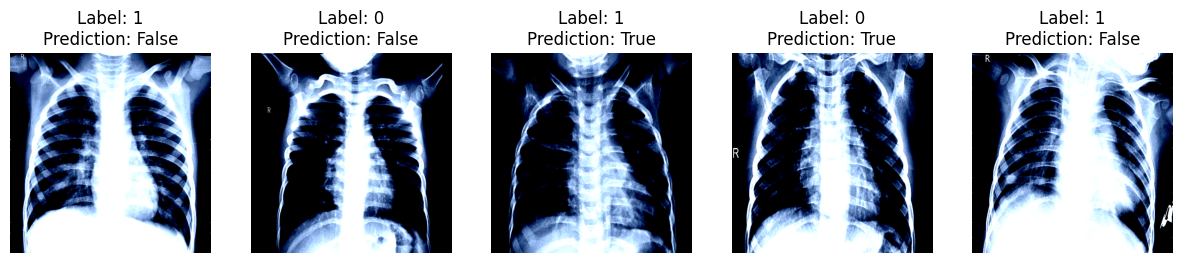

In [ ]:

# Display some images and their predictions
num_images_to_display = 5
indices = torch.randint(len(y_pred), (num_images_to_display,))
indices = indices.tolist()  # Convert indices to a list

# Display some images and their predictions
display_images([test_dataset[i][0] for i in indices], y_true[indices], y_pred[indices])

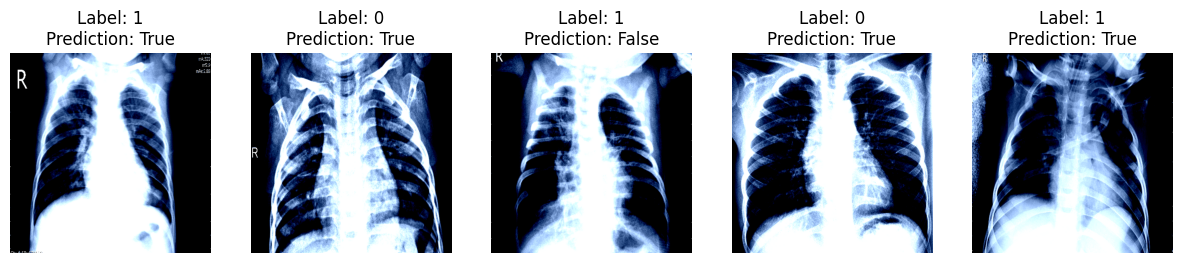

In [ ]:

# Display some images and their predictions
num_images_to_display = 5
indices = torch.randint(len(y_pred), (num_images_to_display,))
indices = indices.tolist()  # Convert indices to a list

# Display some images and their predictions
display_images([test_dataset[i][0] for i in indices], y_true[indices], y_pred[indices])

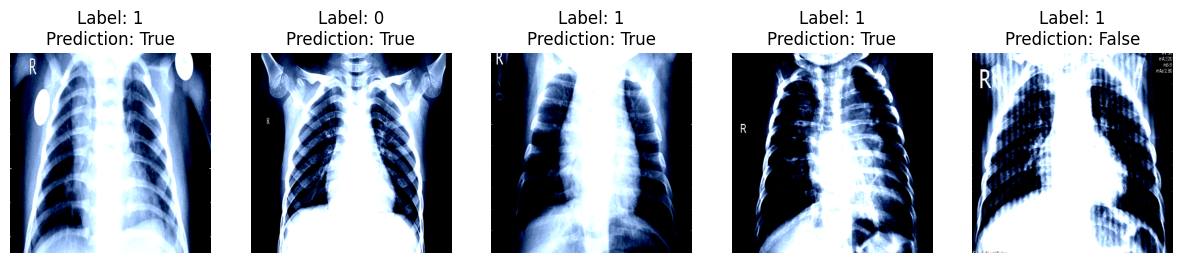

In [ ]:

# Display some images and their predictions
num_images_to_display = 5
indices = torch.randint(len(y_pred), (num_images_to_display,))
indices = indices.tolist()  # Convert indices to a list

# Display some images and their predictions
display_images([test_dataset[i][0] for i in indices], y_true[indices], y_pred[indices])

In [ ]:
def calculate_accuracy(y_true, y_pred):
    correct_predictions = sum((yt == yp).item() for yt, yp in zip(y_true, y_pred))
    total_predictions = len(y_true)
    accuracy = (correct_predictions / total_predictions) * 100
    return accuracy

# Assuming y_true and y_pred are lists of tensors
accuracy = calculate_accuracy(y_true, y_pred)
print(f'Accuracy: {accuracy:.2f}%')


Accuracy: 63.14%


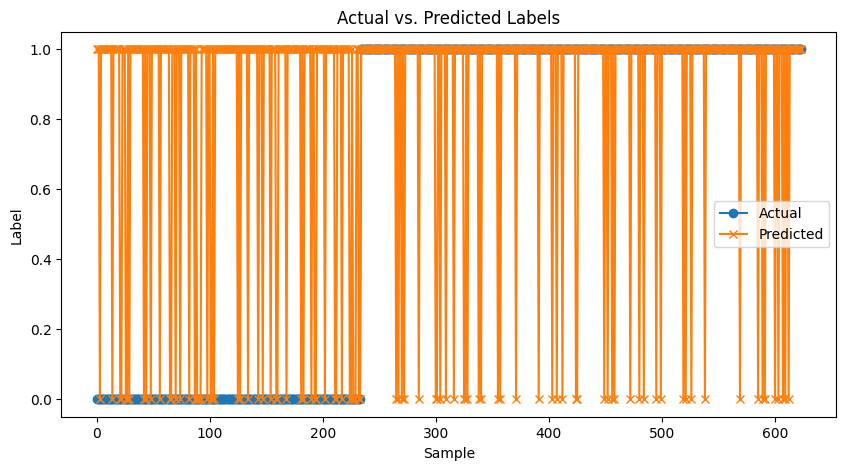

In [ ]:
import matplotlib.pyplot as plt

# Assuming y_true and y_pred are lists of tensors
y_true = [item.item() for sublist in y_true for item in sublist]
y_pred = [item.item() for sublist in y_pred for item in sublist]

plt.figure(figsize=(10, 5))

plt.plot(y_true, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')

plt.xlabel('Sample')
plt.ylabel('Label')
plt.title('Actual vs. Predicted Labels')
plt.legend()
plt.show()


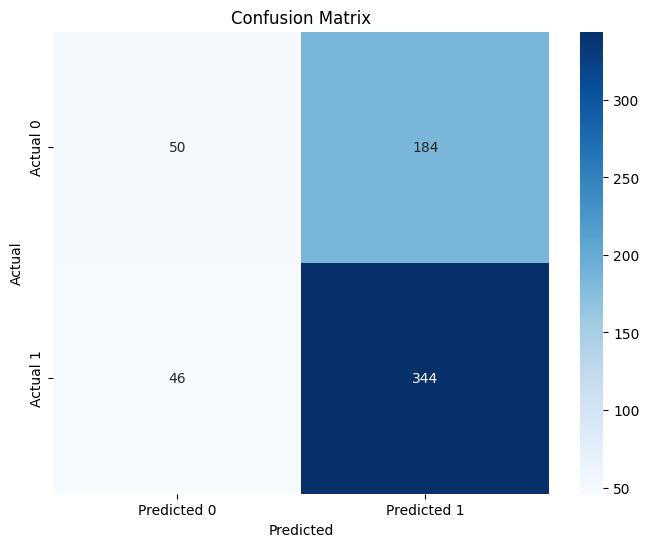

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_true and y_pred are lists or numpy arrays
conf_mat = confusion_matrix(y_true, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


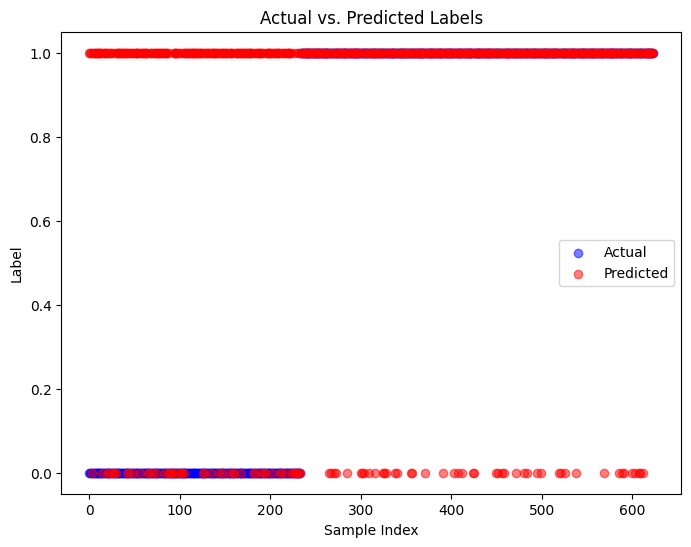

In [ ]:
import matplotlib.pyplot as plt

# Assuming y_true and y_pred are lists or numpy arrays
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_true)), y_true, label='Actual', alpha=0.5, color='blue')
plt.scatter(range(len(y_pred)), y_pred, label='Predicted', alpha=0.5, color='red')
plt.xlabel('Sample Index')
plt.ylabel('Label')
plt.title('Actual vs. Predicted Labels')
plt.legend()
plt.show()


In [ ]:
y_pred = []
y_true = []

for i, (tensors, labels) in tqdm(enumerate(test_dataloader), leave=False, total = len(test_dataloader)):
  with torch.no_grad():
    predictions=model(tensors.cpu())
    predictions= predictions.sigmoid()
    predictions= predictions > 0.5
    y_pred.append(predictions)

    y_true.append(labels)

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
y_pred = torch.cat(y_pred)
y_true = torch.cat(y_true)

NameError: ignored

In [ ]:
y_pred.shape, y_true.shape,

(torch.Size([624, 1]), torch.Size([624, 1]))

In [ ]:
y_pred = y_pred.numpy()
y_true = y_true.numpy()

AttributeError: ignored